# Terzaghi 1D Consolidation (Single Drainage): Uniform IC 
## Analytical Fourier Series vs FEM (FEniCSx)

This notebook verifies a 1D single-layer FEniCSx solution of Terzaghi’s consolidation (diffusion) equation for excess pore pressure against a truncated Fourier-series analytical reference for the standard uniform initial condition.

## Model + methods
- Layer thickness (H); 1D vertical flow.
- Single drainage BCs. (u(0,t)=0) (drained top), (du/dz (H,t)=0) (impermeable base).
- FEM: weak form on a 1D mesh, time integration via Backward Euler.

## Error metrics + convergence
At each time step, FEM is compared to the analytical solution using:
- RMSE over depth
- Normalised (L^2) error over time or whole dimensions.

Convergence studies:
- Mesh refinement (error vs mesh size)
- Time-step refinement (error vs (time step number), including log–log plots)

## Notes
- Early time errors are typically larger due to steep near boundary gradients. Coarse meshes or/and small time steps can exaggerate error. Analytical accuracy depends on Fourier truncation (N terms number), whereas FEM accuracy depends on spatial and temporal resolution. Thus in convergency testing the error is calculated at the last time frame and not through out. This minises when assessing error the large error and the start both in mesh and time.



In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



# set up to allow juypter notebook to use local modulse from src 
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.insert(0, module_path)

from terazaghi_1d.fea_fenicsx import Get_Terazaghi1D_FEA 
from terazaghi_1d.analytical import Get_Terazaghi1d_Analytical


# parameters 
H = 5
num = 50
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 1000
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

# n terms for analitical solution 
N_terms = 200

total_settlement = Mv*P*H

print("\nModel parameters used for analytical and FEM solutions:")
print("--------------------------------------------------------")
print(f"Layer thickness,             = {H:.2f} m")
print(f"Applied surface pressure,    = {P:.2f} kPa")
print(f"Simulation duration,         = {Tx/(60*60*24):.2f} days")
print(f"Number of time steps         = {time_step}")
print(f"Time step size               = {(dt/(60*60*24)):.2f} days")
print(f"Coefficient of consolidation = {Cv:.2e} m^2/s")
print(f"Coefficient of volume comp.  = {Mv:.2e} m^2/kN\n")
print(f"Number of elements (FEM)     = {num}")
print(f"Number of nodes (FEM)        = {nodes}\n")
print(f"Analytical series terms      = {N_terms}\n")
print(f"Dimensionless time factor    = {time_factor:.4f}")
print(f"Total Settlement             = {total_settlement:.4f} m")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Model parameters used for analytical and FEM solutions:
--------------------------------------------------------
Layer thickness,             = 5.00 m
Applied surface pressure,    = 100.00 kPa
Simulation duration,         = 365.00 days
Number of time steps         = 1000
Time step size               = 0.36 days
Coefficient of consolidation = 2.00e-07 m^2/s
Coefficient of volume comp.  = 5.00e-04 m^2/kN

Number of elements (FEM)     = 50
Number of nodes (FEM)        = 51

Analytical series terms      = 200

Dimensionless time factor    = 0.0003
Total Settlement             = 0.2500 m


# FEniCSx Solver
Single Layered FEnicsx Solver, showing outputted local degree of consolidation solution.

In [2]:
# plotting fenicsx data. to note purposely choicen different t or time_step+1 as fenicsx gives t+1 results due to uh ands 
fem_cdata, fem_udata = Get_Terazaghi1D_FEA(H, num, P, Tx, time_step, Cv, 0, True) # 0 as we are using uniform force 
fem_depths = -np.linspace(0, H, num = nodes)
time = np.linspace(0,(Tx/(60*60*24)), num= time_step) 

A = pd.DataFrame(fem_udata, columns = fem_depths, index = time)
A

/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:133: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


,-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-4.1,-4.2,-4.3,-4.4,-4.5,-4.6,-4.7,-4.8,-4.9,-5.0
0.000000,0.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.365365,0.0,65.120154,91.045603,97.701216,99.409853,99.848497,99.961106,99.990015,99.997437,99.999342,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.730731,0.0,49.601860,79.866212,92.983987,97.724614,99.294116,99.787530,99.937431,99.981877,99.994819,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1.096096,0.0,41.108532,70.875159,87.442964,95.091105,98.209316,99.378996,99.792719,99.932846,99.978756,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1.461461,0.0,35.735565,63.976479,82.105425,91.947185,96.647972,98.687624,99.510579,99.824501,99.939058,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363.538539,0.0,2.166777,4.331295,6.491299,8.644541,10.788782,12.921796,15.041374,17.145324,19.231481,...,65.670303,66.227160,66.719588,67.147182,67.509587,67.806506,68.037695,68.202965,68.302181,68.335262
363.903904,0.0,2.165352,4.328447,6.487033,8.638862,10.781699,12.913319,15.031514,17.134097,19.218902,...,65.629935,66.186499,66.678671,67.106041,67.468258,67.765023,67.996093,68.161278,68.260443,68.293507
364.269269,0.0,2.163928,4.325602,6.482770,8.633188,10.774622,12.904849,15.021664,17.122880,19.206334,...,65.589590,66.145861,66.637775,67.064923,67.426951,67.723562,67.954513,68.119612,68.218726,68.251773
364.634635,0.0,2.162506,4.322759,6.478511,8.627520,10.767551,12.896387,15.011822,17.111673,19.193777,...,65.549267,66.105245,66.596901,67.023826,67.385666,67.682123,67.912954,68.077968,68.177030,68.210060


# Analytical Solver
Showing outputted local degree of consolidation solution.

In [3]:
# analytical solution plotitng 
analytical_cdata, analytical_udata, depth, time = Get_Terazaghi1d_Analytical(H, num, P, Tx, time_step, Cv, N_terms)


B = pd.DataFrame(analytical_udata, columns= -depth, index= time) # showing result table 
B


,-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-4.1,-4.2,-4.3,-4.4,-4.5,-4.6,-4.7,-4.8,-4.9,-5.0
0.000000,0.0,94.993101,97.473178,98.311168,98.731144,98.983121,99.150932,99.270598,99.360152,99.429622,...,99.834266,99.835684,99.836919,99.837976,99.838862,99.839581,99.840137,99.840531,99.840767,99.840846
0.365365,0.0,62.648948,92.489683,99.240924,99.962868,99.999140,99.999991,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.730731,0.0,47.082524,79.180077,94.094703,98.816630,99.834667,99.984038,99.998941,99.999952,99.999999,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1.096096,0.0,39.260380,69.585609,87.677598,96.013790,98.979983,99.794911,99.967754,99.996049,99.999624,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1.461461,0.0,34.365021,62.648948,81.808284,92.489683,97.390481,99.240924,99.815874,99.962868,99.993788,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363.538539,0.0,2.166485,4.330713,6.490431,8.643391,10.787356,12.920101,15.039419,17.143121,19.229039,...,65.667508,66.224447,66.716952,67.144613,67.507077,67.804044,68.035272,68.200570,68.299803,68.332890
363.903904,0.0,2.165061,4.327867,6.486166,8.637714,10.780275,12.911626,15.029563,17.131897,19.216464,...,65.627128,66.183775,66.676021,67.103459,67.465734,67.762547,67.993655,68.158868,68.258049,68.291119
364.269269,0.0,2.163638,4.325022,6.481905,8.632042,10.773200,12.903159,15.019716,17.120684,19.203900,...,65.586771,66.143124,66.635112,67.062326,67.424413,67.721072,67.952060,68.117187,68.216317,68.249370
364.634635,0.0,2.162216,4.322181,6.477647,8.626375,10.766132,12.894700,15.009877,17.109480,19.191347,...,65.546435,66.102495,66.594225,67.021216,67.383113,67.679618,67.910487,68.075528,68.174607,68.207642


# Computing for Error (RMSE & L2)


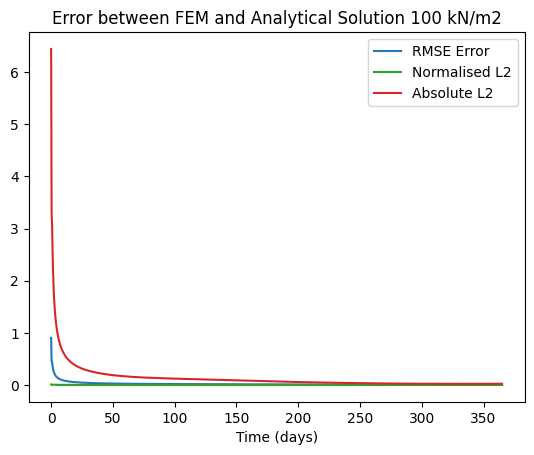

In [4]:
# assumes that the t and z for both data is identical in which it is 
error = fem_udata - analytical_udata

# RMSE error per time step 
RMSE = np.sqrt((error**2).mean(axis = 1))


# Normalised L2 norm error 
num = (error**2).sum(axis = 1)
den = (analytical_udata**2).sum(axis = 1)
norm_L2 = np.sqrt(num / (den + 1e-12))
abs_L2 = np.sqrt(num)

# plotting err
plt.figure()
plt.plot(time, RMSE, label = "RMSE Error")
plt.plot([0,np.max(time)],[0,0], linestyle ="dotted")  # Please change for capture of map
plt.plot(time, norm_L2, label = "Normalised L2")
plt.plot(time,abs_L2, label = "Absolute L2")
plt.xlabel("Time (days)")
plt.legend()
plt.title( f"Error between FEM and Analytical Solution {P} kN/m2")
plt.show()


# Settlement Plots

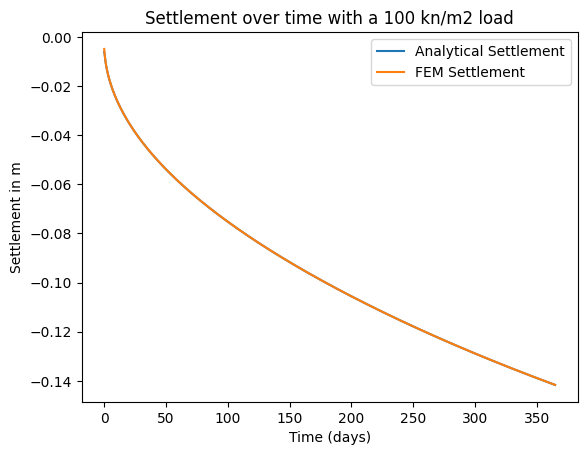

Analytical: 0.1417m 
FEM: 0.1416m 
Actual total settlememt: 0.25 


In [5]:

# drawing settlement with time plotting 
analytical_settlement= analytical_cdata.mean(axis=1)*total_settlement
fem_settlement = fem_cdata.mean(axis=1)*total_settlement

plt.figure()
plt.plot(time, -analytical_settlement, label="Analytical Settlement")
plt.plot(time, -fem_settlement, label="FEM Settlement")
plt.xlabel("Time (days)")
plt.ylabel("Settlement in m")
plt.legend()
plt.title(f"Settlement over time with a {P} kn/m2 load")
plt.show()
print(f"Analytical: {np.max(analytical_settlement):.4f}m \nFEM: {np.max(fem_settlement):.4}m \nActual total settlememt: {total_settlement:.4} ")

# Heat Map Representation through out time 
note: these use local degree of consolidation and not settlement

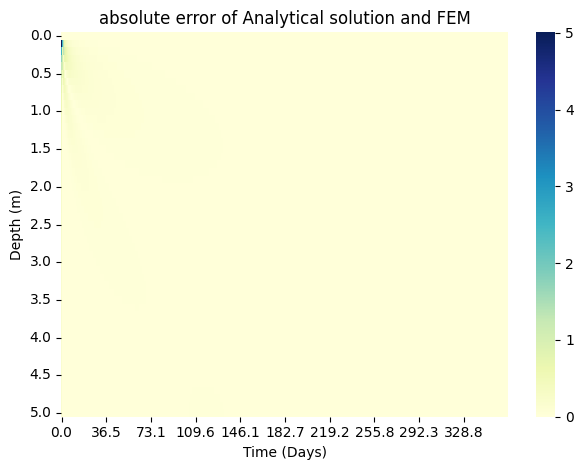

In [6]:

kx = max(1, len(time)//10)    # ~8 labels across, auto
ky = max(1, len(depth)//10)  # ~10 labels down, auto 


ax = sns.heatmap(abs(error).T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)

ax.set_xlabel("Time (Days)")
ax.set_ylabel("Depth (m)")
ax.set_title("absolute error of Analytical solution and FEM")
plt.tight_layout()
plt.show()




## Mesh and time-step convergence

To ensure the analytical reference remains sufficiently accurate for fine discretisations, the Fourier series truncation was increased (from 200 to 400 terms). As the mesh is refined, the time step is also reduced to avoid temporal error dominating the spatial convergence results (fine meshes are more sensitive to (time steps numbers)).

Some early-time error remains due to sharp near-boundary gradients and Fourier truncation effects, but the overall trend should show decreasing error with refinement.


In [7]:
Tx = 60*60*24*50 # seconds to a year Please keeps this within days 
time_step = 3000

dt = Tx / time_step
mesh_size = [5,10,20,40, 80] # add in 100 and 200
time_step = 5000 



N_terms = 400

mesh_size = np.array(mesh_size, dtype = int)
time_step = np.array(time_step, dtype = int)
RMSE_mesh = []
norm_L2_mesh = []
abs_L2_mesh = []

for nx in mesh_size:
    fem_cdata, fem_udata = Get_Terazaghi1D_FEA(H, nx, P, Tx, time_step, Cv, 0, True)
    analytical_cdata, analytical_udata, a_Z, a_t = Get_Terazaghi1d_Analytical(H, nx, P, Tx, time_step, Cv, N_terms)

    fem_udata = np.asarray(fem_udata, float)
    analytical_udata = np.asarray(analytical_udata, float)

    # L2 abs error at final time
    errT = fem_udata[-1, :] - analytical_udata[-1, :]
    dz = H / (len(errT) - 1)
    abs_L2 = np.sqrt(np.sum(errT**2) * dz)
    abs_L2_mesh = np.append(abs_L2_mesh, abs_L2)

    # Normalise by initial analytical norm (fixed reference)
    U0 = analytical_udata[0, :]
    L2_den = np.sqrt(np.sum(U0**2) * dz)
    norm_L2 = abs_L2 / (L2_den + 1e-30)
    norm_L2_mesh = np.append(norm_L2_mesh, norm_L2)

    print(f"Mesh Size: {H/nx:3f}, normalised L2: {norm_L2:3e}, absolute {abs_L2:3e}")


/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:133: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


Mesh Size: 1.000000, normalised L2: 2.214611e-02, absolute 4.945539e+00
Mesh Size: 0.500000, normalised L2: 5.928228e-03, absolute 1.323445e+00
Mesh Size: 0.250000, normalised L2: 1.502483e-03, absolute 3.353103e-01
Mesh Size: 0.125000, normalised L2: 3.683623e-04, absolute 8.217997e-02
Mesh Size: 0.062500, normalised L2: 8.278641e-05, absolute 1.851825e-02


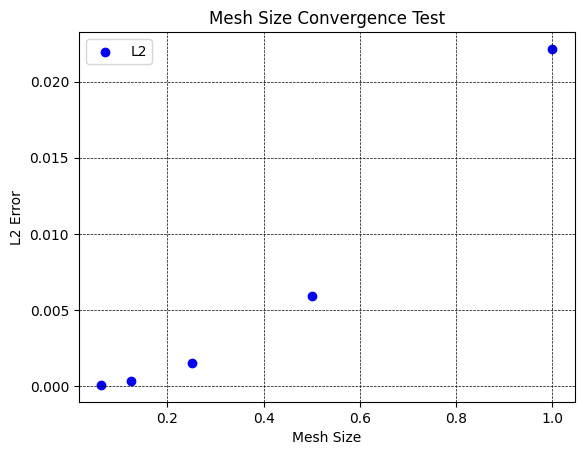

norm L2 plot: 2.33e-02x^2.013529, R^2 = 0.99945


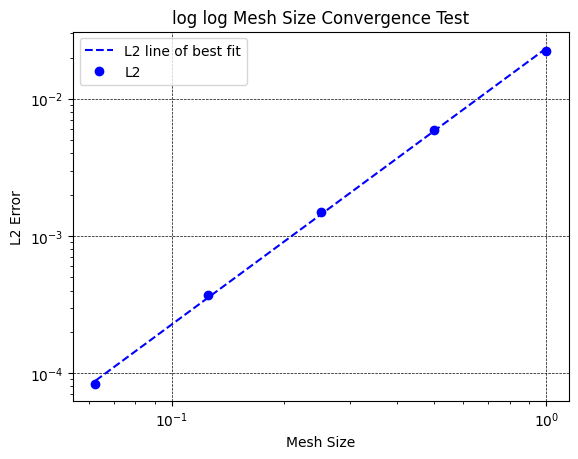

In [8]:
# raw scatter plotting 
h = H / mesh_size

plt.scatter(h, norm_L2_mesh, label = "L2", color = "b")
plt.grid(color = "black", linestyle = "--", linewidth = "0.5",)
plt.xlabel("Mesh Size")
plt.ylabel("L2 Error")
plt.title("Mesh Size Convergence Test")
plt.legend()
plt.show()



# linear regression for L2 for mesh
x_L2 = np.log(h)
y_L2 = np.log(norm_L2_mesh)
p_L2, logC_L2 = np.polyfit(x_L2,y_L2, 1)
C_L2 = np.exp(logC_L2) 
Y_linearL2 = C_L2 * h**p_L2
# R2 
yhat_L2 = p_L2*x_L2 + logC_L2
ss_res_L2 = np.sum((y_L2 - yhat_L2)**2)
ss_tot_L2 = np.sum((y_L2 - y_L2.mean())**2)
r2_L2 = 1 - ss_res_L2/ss_tot_L2


print(f"norm L2 plot: {C_L2:.2e}x^{p_L2:4f}, R^2 = {r2_L2:.5f}")



plt.loglog(h, Y_linearL2, linestyle = "--", label= f"L2 line of best fit", color = "b")
plt.loglog(h,norm_L2_mesh, linestyle = "None", marker = "o", label = 'L2', color = "b")

plt.grid(color = "black", linestyle = "--", linewidth = "0.5")
plt.xlabel("Mesh Size")
plt.ylabel("L2 Error")
plt.title("log log Mesh Size Convergence Test")
plt.legend()
plt.show()


In [20]:
num = 200
time_steps = np.array([100, 200, 400, 800,1600], dtype=int)

norm_L2_time = []
dt_list = []
for i in time_steps:
    fem_cdata, fem_udata = Get_Terazaghi1D_FEA(H, num, P, Tx, i, Cv, 0, True)

    # MAKE SURE this matches your actual function signature
    analytical_cdata, analytical_udata, a_Z, a_T = Get_Terazaghi1d_Analytical(H, num, P, Tx, i, Cv, N_terms)

    dt = Tx / i
    dt_list.append(dt)

    fem_udata = np.asarray(fem_udata, float)
    analytical_udata = np.asarray(analytical_udata, float)

    errT = fem_udata[-1, :] - analytical_udata[-1, :]
    dz = H / (len(errT) - 1)

    abs_L2 = np.sqrt(np.sum(errT**2) * dz)

    U0 = analytical_udata[0, :]
    L2_den = np.sqrt(np.sum(U0**2) * dz)
    norm_L2 = abs_L2 / (L2_den + 1e-30)
    norm_L2_time.append(norm_L2)

    print(f"{i} steps (dt={dt/(60*60*24):.3f}days), norm L2={norm_L2:.3e}, abs L2={abs_L2:.3e}")


100 steps (dt=3.650days), norm L2=9.568e-04, abs L2=2.141e-01
200 steps (dt=1.825days), norm L2=4.744e-04, abs L2=1.062e-01
400 steps (dt=0.912days), norm L2=2.347e-04, abs L2=5.251e-02
800 steps (dt=0.456days), norm L2=1.152e-04, abs L2=2.578e-02
1600 steps (dt=0.228days), norm L2=5.556e-05, abs L2=1.243e-02


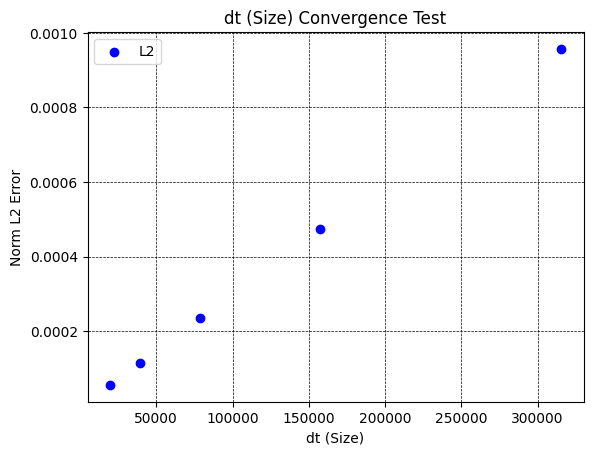

L2 plot: 2.22e-09*x^1.025421, R^2 = 0.99994


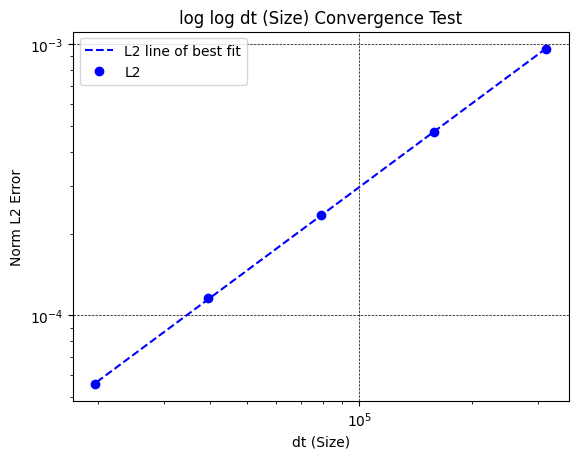

In [21]:
# raw scatter plotting 
plt.scatter(dt_list, norm_L2_time, label = "L2", color = "b")
plt.grid(color = "black", linestyle = "--", linewidth = "0.5",)
plt.xlabel("dt (Size)")
plt.ylabel("Norm L2 Error")
plt.title("dt (Size) Convergence Test")
plt.legend()
plt.show()




# linear regression for L2 for mesh
x_L2 = np.log(dt_list)
y_L2 = np.log(norm_L2_time)
p_L2, logC_L2 = np.polyfit(x_L2,y_L2, 1)
C_L2 = np.exp(logC_L2) 
Y_linearL2 = C_L2 * dt_list**p_L2
# R2 
yhat_L2 = p_L2*x_L2 + logC_L2
ss_res_L2 = np.sum((y_L2 - yhat_L2)**2)
ss_tot_L2 = np.sum((y_L2 - y_L2.mean())**2)
r2_L2 = 1 - ss_res_L2/ss_tot_L2


print(f"L2 plot: {C_L2:.2e}*x^{p_L2:4f}, R^2 = {r2_L2:.5f}")


plt.loglog(dt_list, Y_linearL2, linestyle = "--", label= f"L2 line of best fit", color = "b")
plt.loglog(dt_list,norm_L2_time, linestyle = "None", marker = "o", label = 'L2', color = "b")

plt.grid(color = "black", linestyle = "--", linewidth = "0.5")
plt.xlabel("dt (Size)")
plt.ylabel("Norm L2 Error")
plt.title("log log dt (Size) Convergence Test")
plt.legend()
plt.show()
